In [35]:
import wfdb
import wfdb.processing
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Download data if it is not in data folder

In [2]:
wfdb.dl_database("mitdb", "data/mit-bih", annotators='all')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [3]:
data = 'data/mit-bih/'

In [4]:
# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

# Non Beat Symbols
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

# Abnormal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Classification based on AAMI
AAMI = ['N','L','R','B','A','a','j','S','V','r','F','e','j','n','E','f','/','Q','?']

# Normal Beat Symbols
normal = ['N']

dic = {'N':['N','L','R','B'],
       'S':['A','a','j','S','e','j','n'],
       'V':['V','r','E'],
       'F':['F'],
       'Q':['Q','?','f','/'],
      }


In [5]:
record = wfdb.rdrecord(data+'100',smooth_frames=True)
record.p_signal.shape
# first entry is MLII (Lead II) and second is V1 (sometimes V2, V4, or V5) 

(650000, 2)

In [6]:
t = [x/360 for x in list(range(10800))]

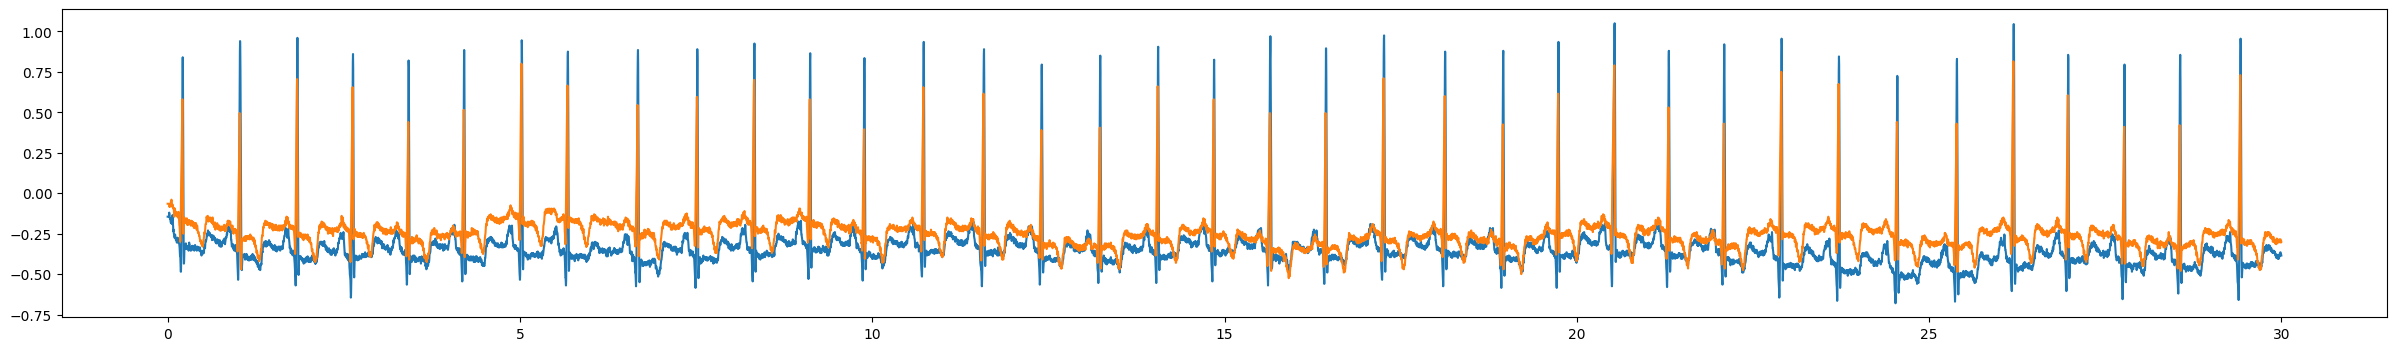

In [7]:
plt.figure(figsize=(30, 4))
plt.plot(t, record.p_signal[:10800,0])
plt.plot(t, record.p_signal[:10800,1])

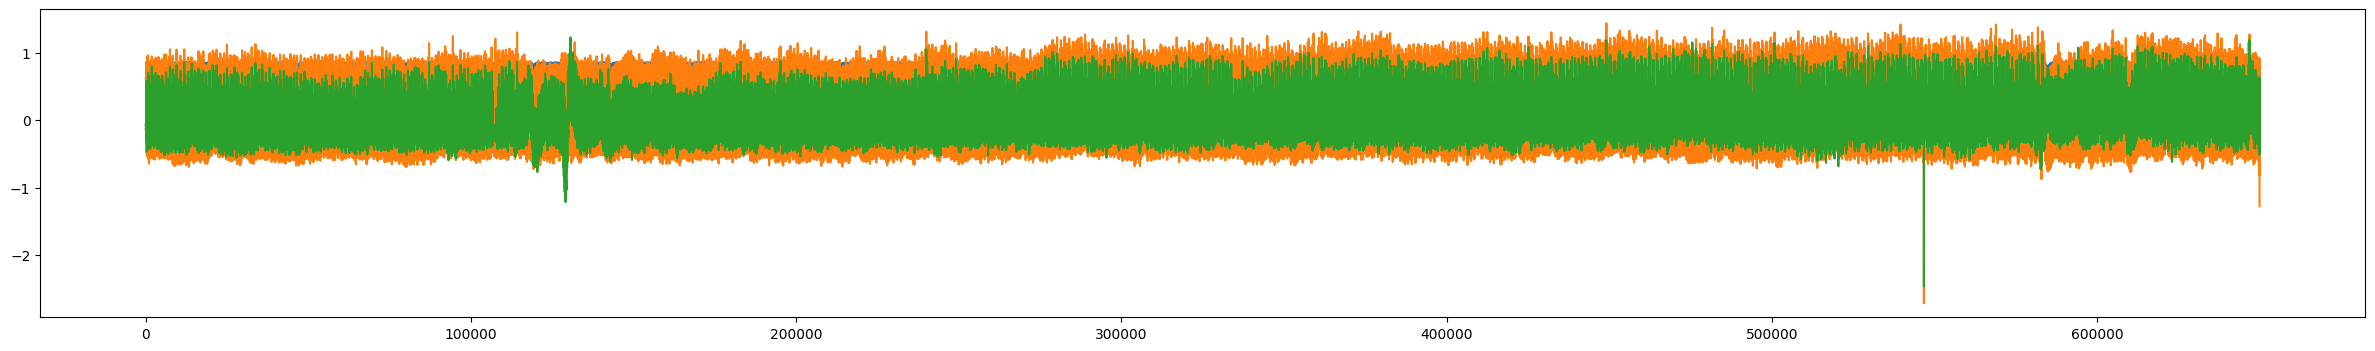

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
lm = min_max_scaler.fit_transform(record.p_signal[:,0].reshape(-1,1)).squeeze()
plt.figure(figsize=(30, 4))
plt.plot(lm)
plt.plot(record.p_signal)

In [9]:
qrs = wfdb.processing.XQRS(lm, fs=360)
qrs.detect()

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


In [10]:
ann = wfdb.rdann(data+"100", extension="atr")
(ann.symbol[0])

'+'

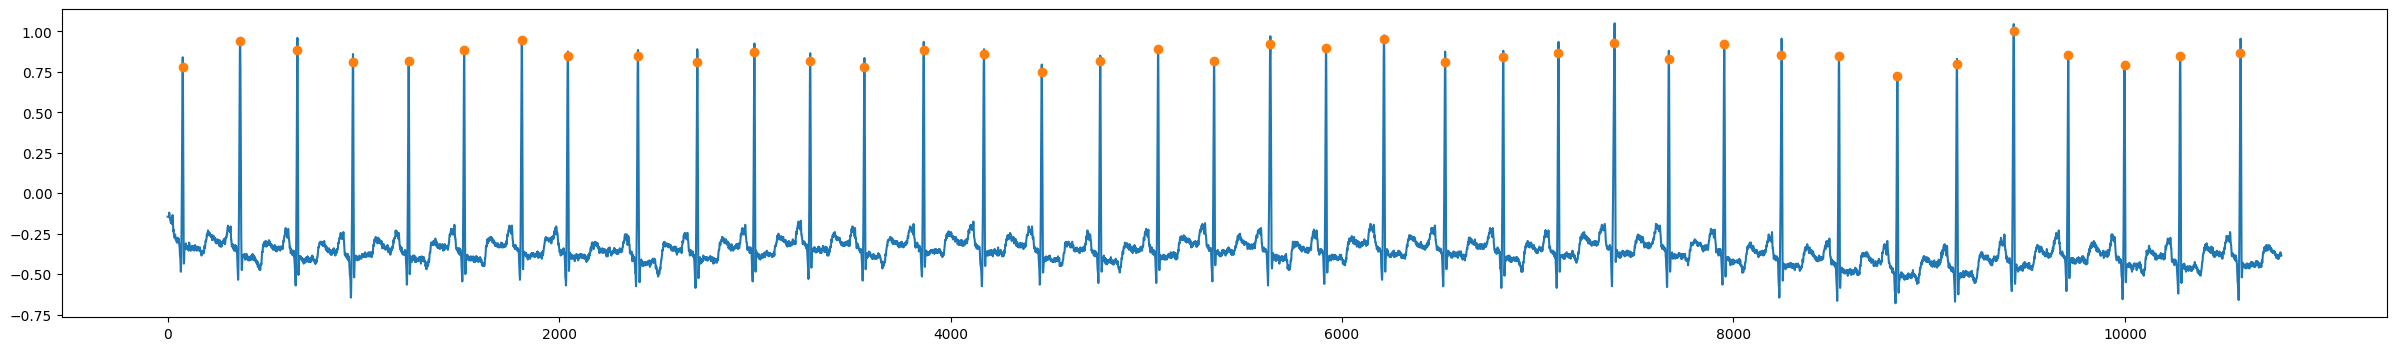

In [11]:
plt.figure(figsize=(30, 4))
plt.plot(record.p_signal[:10800,0])
plt.plot(qrs.qrs_inds[qrs.qrs_inds<10800], record.p_signal[qrs.qrs_inds[qrs.qrs_inds<10800], 0], marker="o", linestyle="none")

In [12]:
sum(ann.sample[1::] != qrs.qrs_inds)

412

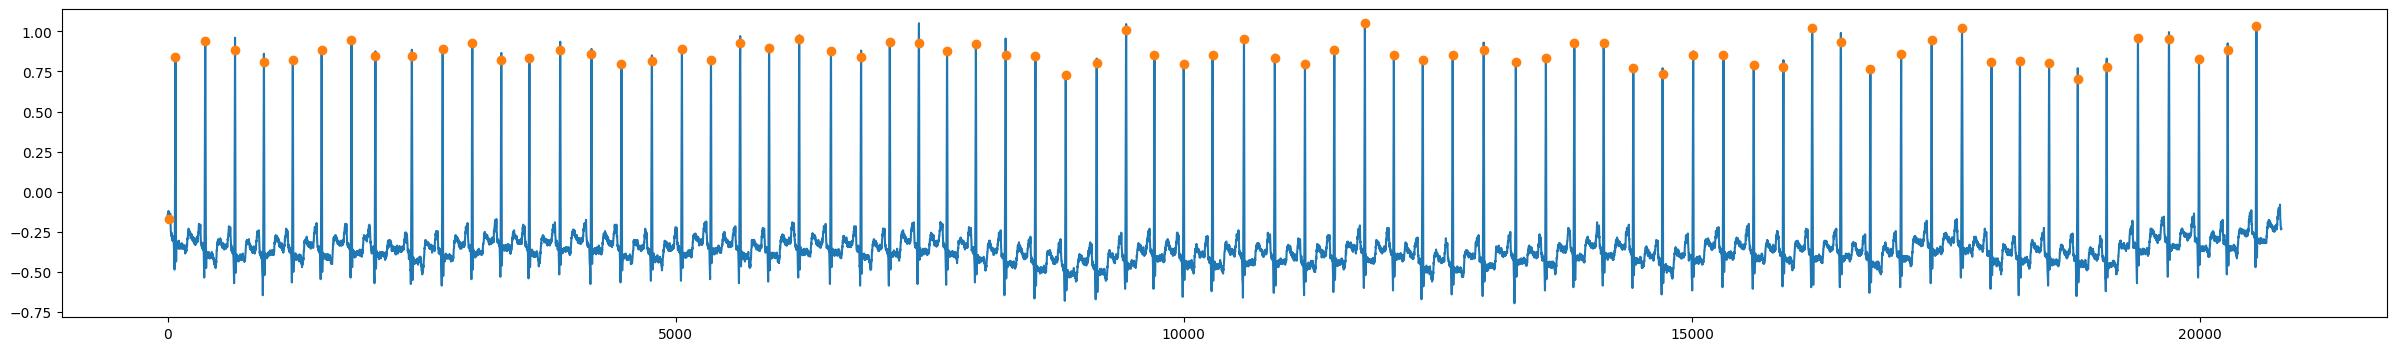

In [13]:
ann = wfdb.rdann(data+"100", extension="atr")
plt.figure(figsize=(30, 4))
plt.plot(record.p_signal[:20800,0])
plt.plot(ann.sample[ann.sample<20800], record.p_signal[ann.sample[ann.sample<20800], 0], marker="o", linestyle="none")

In [23]:
df = []
ann_list = []
window_size = 180 #seems to be common roughly 1 heartbeat
for pat_id in patients:
    print('record number', pat_id)
    record = wfdb.rdrecord(data+pat_id,smooth_frames=True)
    ann = wfdb.rdann(data+pat_id, extension="atr")
    min_max_scaler = preprocessing.MinMaxScaler()
    lm = min_max_scaler.fit_transform(record.p_signal[:,0].reshape(-1,1)).squeeze()
    qrs = wfdb.processing.XQRS(lm, fs=360)
    qrs.detect()
    peaks = qrs.qrs_inds

    for i, ann_idx in enumerate(ann.sample[1:-1]):
        start,end = ann_idx-window_size//2, ann_idx+window_size//2
        df.append(list(lm[start:end]))
        beat_type = "A" if ann.symbol[i+1] != "N" else "N"

        ann_list.append(beat_type)

    
    # for i, peak in enumerate(peaks[1:-1]):
    #     start,end = peak-window_size//2, peak+window_size//2
    #     df.append(list(lm[start:end]))


record number 100
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
record number 101
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
record number 102
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
record number 103
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
record number 104
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
record number 105
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Runni

In [24]:
len(df)

112551

In [31]:
ann_list[7]

'A'

In [25]:
set(ann_list)

{'A', 'N'}

'N'

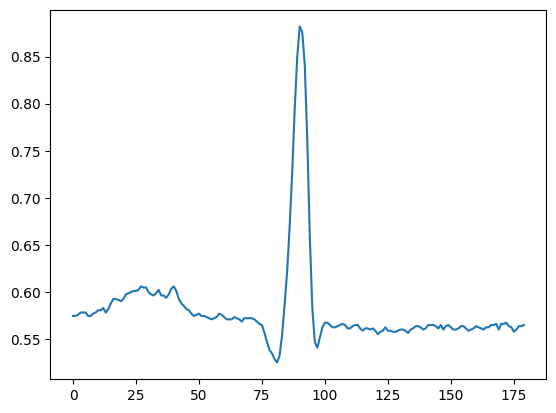

In [33]:
plt.plot(df[6])
ann_list[6]

'A'

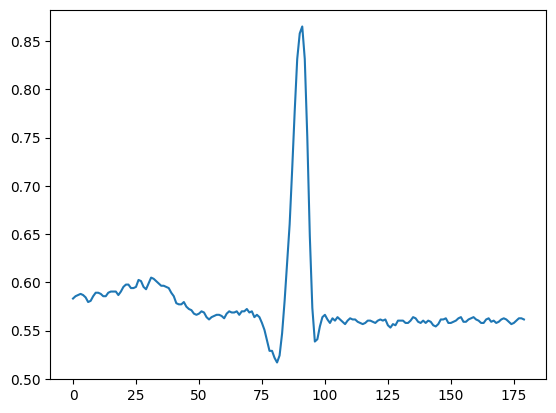

In [32]:
plt.plot(df[7])
ann_list[7]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df, ann_list, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=1)


In [40]:
print(f"train set: {len(X_train)}")
print(f"val set: {len(X_val)}")
print(f"test set: {len(X_test)}")

train set: 80036
val set: 10004
test set: 22511


In [34]:
pd.DataFrame(X_train, columns=[f"t_{i}" for i in range(180)]).to_csv("data/mit_bih_train.csv")
pd.DataFrame(y_train, columns=["beat_type"]).to_csv("data/beat_type_train.csv")

pd.DataFrame(X_test, columns=[f"t_{i}" for i in range(180)]).to_csv("data/mit_bih_test.csv")
pd.DataFrame(y_test, columns=["beat_type"]).to_csv("data/beat_type_test.csv")

pd.DataFrame(X_val, columns=[f"t_{i}" for i in range(180)]).to_csv("data/mit_bih_val.csv")
pd.DataFrame(y_val, columns=["beat_type"]).to_csv("data/beat_type_val.csv")